<a href="https://colab.research.google.com/github/optimopium/is-this-political/blob/main/strategies/Discrepancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installs

In [1]:
! pip install --quiet -U transformers
! pip install --quiet datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.7 MB/s eta 0:00:00


### Prelimenaries

In [2]:
import gdown

url = "https://drive.google.com/drive/folders/1B4s1JgxRKWJB4IrRVjE5wWNjM-sNSQT3"
gdown.download_folder(url, output="./", quiet=True, use_cookies=False)

['./dataset/test.csv', './dataset/train.csv', './dataset/validation.csv']

In [3]:
base_dir = './dataset/'
data_files = {"train": base_dir + "train.csv", "validation": base_dir + "validation.csv", "test": base_dir + "test.csv"}

In [4]:
! mkdir results

In [5]:
import random
import numpy as np

import torch
import torch.nn as nn

from datasets import load_dataset

In [6]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed()

In [7]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
import logging

# Creating an object
logger = logging.getLogger()
 
# Setting the threshold of logger to DEBUG
logger.setLevel(logging.INFO)

In [9]:
# General variables
MAX_SEQ_LEN = 128
UNLABELED_BATCH_SIZE = 32
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
LEARNING_RATE = 5e-5
EPS = 1e-8
LOGGING_STEPS = 50
EVAL_STEPS = 30
D_IN = 768
D_OUT = 2
# epoch * (budget/batch size)
BASE_MODEL = 'xlm-roberta-base'
MAX_STEPS = 500
EPOCHS = int(MAX_STEPS/TRAIN_BATCH_SIZE)
MODEL_OUTPUT_DIR = "results/model/"
HEAD_CLASSIFIER_DROP_OUT = 0.1
CLASSIFIER_DROP_OUT = 0.35
CLASSIFIER_HIDDEN_LAYER_SIZE = 32
AUX_CLASSIFIER_HIDDEN_LAYER_SIZE = 10

BUDGET = 750
INITIAL_DATASET_SIZE = 150
ACQUISITION_SIZE = 100
ITERATIONS = int((BUDGET - INITIAL_DATASET_SIZE) / ACQUISITION_SIZE)

print(f"Budget: {BUDGET}")
print(f"Initial Dataset Size: {INITIAL_DATASET_SIZE}")
print(f"Acquisition size: {ACQUISITION_SIZE}")
print(f"Iterations: {ITERATIONS}")

Budget: 750
Initial Dataset Size: 150
Acquisition size: 100
Iterations: 6


In [10]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

### Cross Entorpy Loss

In [11]:
ce_loss = nn.CrossEntropyLoss()

### Create Dataset Embeddings

In [12]:
from datasets import ClassLabel

c2l = ClassLabel(num_classes=2, names=['Nonpolitical', 'Political'])

In [13]:
from torch.utils.data import TensorDataset

def transform_to_embedding_dataset(tokenizer, dataset, is_bert=False):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    labels = []

    for item in dataset:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            item["sentence1"],                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 256,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
        input_ids.append(encoded_dict["input_ids"])
        attention_masks.append(encoded_dict["attention_mask"])
        if is_bert:
            token_type_ids.append(encoded_dict["token_type_ids"])

        labels.append(c2l.str2int(item["label"]))


    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    if is_bert:
        token_type_ids = torch.cat(token_type_ids, dim=0)
    labels = torch.tensor(labels)
    


    # Combine the training inputs into a TensorDataset.
    if is_bert:
        dataset = TensorDataset(input_ids, attention_masks, token_type_ids, labels)
    else:
        dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

### Model

In [14]:
from transformers import AutoConfig, AutoModel

from transformers import AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

### Train Loop

In [15]:
from tqdm import tqdm
from torch.utils.data import SequentialSampler, DataLoader

def train(train_dataset, validation_dataset, is_bert=False):
    # Creating dataloaders
    logging.info("Creating Dataloaders.")
    train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

    logging.info("Instantiating models.")
    base_model = AutoModel.from_pretrained(BASE_MODEL).to(DEVICE)
    head = nn.Sequential(
            nn.Dropout(HEAD_CLASSIFIER_DROP_OUT),
            nn.Linear(D_IN, CLASSIFIER_HIDDEN_LAYER_SIZE),
            nn.Tanh(),
            nn.Dropout(HEAD_CLASSIFIER_DROP_OUT),
            nn.Linear(CLASSIFIER_HIDDEN_LAYER_SIZE, D_OUT),
        ).to(DEVICE)

    logging.info("Optimizer and Scheduler setup.")
    optimizer = AdamW([
                    {'params': base_model.parameters()},
                    {'params': head.parameters()}
                ], lr=LEARNING_RATE, eps=EPS)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=MAX_STEPS)

    # Start training loop
    logging.info("Training")
    for epoch_i in tqdm(range(EPOCHS)):
        # Print the header of the result table
        print(f"\n{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12}")
        print("-"*45)
        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        base_model.train()
        head.train()

        for step, t_batch in enumerate(train_dataloader):
            batch_counts +=1

            t_batch = tuple(t.to(DEVICE) for t in t_batch)
            if is_bert:
                inputs = {"input_ids": t_batch[0], "attention_mask": t_batch[1], "token_type_ids": t_batch[2]}
            else:
                inputs = {"input_ids": t_batch[0], "attention_mask": t_batch[1]}


            # Update Primary Model
            unfreeze_model(base_model)
            optimizer.zero_grad()

            base_outputs = base_model(**inputs)
            last_hidden_state_cls = base_outputs[0][:, 0, :]
            head_outputs = head(last_hidden_state_cls)

            if is_bert:
                head_loss = ce_loss(head_outputs, t_batch[3])
            else:
                head_loss = ce_loss(head_outputs, t_batch[2])

            head_loss.backward()

            batch_loss += head_loss

            torch.nn.utils.clip_grad_norm_(base_model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

        # Print the loss values and time elapsed for every 20 batches
        if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
            # Print training results
            print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f}")

            # Reset batch tracking variables
            batch_loss, batch_counts = 0, 0

        # After the completion of each training epoch, measure the model's performance
        # on our validation set.
        head_val_loss, head_val_accuracy = evaluate(base_model, head, validation_dataset)
        logging.info(f"Evaluation Head:: Loss={head_val_loss} Accuracy={head_val_accuracy}")

        return base_model, head

In [16]:
from tqdm import tqdm

def discrepancy_train(train_dataset, validation_dataset, unlabeled_dataset, is_bert=False):
    # Creating dataloaders
    logging.info("Creating Dataloaders.")
    train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=UNLABELED_BATCH_SIZE, shuffle=True)

    logging.info("Instantiating models.")
    base_model = AutoModel.from_pretrained(BASE_MODEL).to(DEVICE)
    head = nn.Sequential(
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(D_IN, CLASSIFIER_HIDDEN_LAYER_SIZE),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(CLASSIFIER_HIDDEN_LAYER_SIZE, D_OUT),
        ).to(DEVICE)
    classifier1 = nn.Sequential(
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(D_IN, AUX_CLASSIFIER_HIDDEN_LAYER_SIZE),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(AUX_CLASSIFIER_HIDDEN_LAYER_SIZE, D_OUT),
        ).to(DEVICE)
    classifier2 = nn.Sequential(
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(D_IN, AUX_CLASSIFIER_HIDDEN_LAYER_SIZE),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(AUX_CLASSIFIER_HIDDEN_LAYER_SIZE, D_OUT),
        ).to(DEVICE)


    logging.info("Optimizer and Scheduler setup.")
    optimizer = AdamW([
                    {'params': base_model.parameters()},
                    {'params': head.parameters()}
                ], lr=LEARNING_RATE, eps=EPS)
    clf_optimizer = AdamW([
                    {'params': classifier1.parameters()},
                    {'params': classifier2.parameters()}
                ], lr=LEARNING_RATE, eps=EPS)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=MAX_STEPS)

    logging.info("Discrepancy Training")

    for epoch_i in tqdm(range(EPOCHS)):
        # Print the header of the result table
        print(f"\n{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12}")
        print("-"*45)
        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        base_model.train()
        head.train()
        classifier1.train()
        classifier2.train()

        for step, (t_batch, u_batch) in enumerate(zip(train_dataloader, unlabeled_dataloader)):
            batch_counts +=1

            t_batch = tuple(t.to(DEVICE) for t in t_batch)
            if is_bert:
                inputs = {"input_ids": t_batch[0], "attention_mask": t_batch[1], "token_type_ids": t_batch[2]}
            else:
                inputs = {"input_ids": t_batch[0], "attention_mask": t_batch[1]}

            # Update Primary Model
            unfreeze_model(base_model)
            optimizer.zero_grad()

            base_outputs = base_model(**inputs)
            last_hidden_state_cls = base_outputs[0][:, 0, :]
            last_hidden_state_cls_detached = last_hidden_state_cls.detach()
            head_outputs = head(last_hidden_state_cls)

            if is_bert:
                head_loss = ce_loss(head_outputs, t_batch[3])
            else:
                head_loss = ce_loss(head_outputs, t_batch[2])

            head_loss.backward()

            batch_loss += head_loss

            # torch.nn.utils.clip_grad_norm_(base_model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Update Auxlary Models
            freeze_model(base_model)
            clf_optimizer.zero_grad()

            classifier1_outputs = classifier1(last_hidden_state_cls_detached)
            classifier2_outputs = classifier2(last_hidden_state_cls_detached)

            if is_bert:
                classifier1_loss = ce_loss(classifier1_outputs, t_batch[3])
                classifier2_loss = ce_loss(classifier2_outputs, t_batch[3])
            else:
                classifier1_loss = ce_loss(classifier1_outputs, t_batch[2])
                classifier2_loss = ce_loss(classifier2_outputs, t_batch[2])

            classifiers_loss = classifier1_loss + classifier2_loss

            classifiers_loss.backward()
            clf_optimizer.step()


            # Unlabled Data
            u_batch = tuple(t.to(DEVICE) for t in u_batch)
            if is_bert:
                u_inputs = {"input_ids": u_batch[0], "attention_mask": u_batch[1], "token_type_ids": u_batch[2]}
            else:
                u_inputs = {"input_ids": u_batch[0], "attention_mask": u_batch[1]}

            base_outputs = base_model(**u_inputs)
            last_hidden_state_cls = base_outputs[0][:, 0, :].detach()

            head_outputs = head(last_hidden_state_cls)
            classifier1_outputs = classifier1(last_hidden_state_cls)
            classifier2_outputs = classifier2(last_hidden_state_cls)


            base_outputs = base_model(**inputs)
            last_hidden_state_cls = base_outputs[0][:, 0, :]
            last_hidden_state_cls_detached = last_hidden_state_cls.detach()
            classifier1_outputs = classifier1(last_hidden_state_cls_detached)
            classifier2_outputs = classifier2(last_hidden_state_cls_detached)

            if is_bert:
                classifier1_loss = ce_loss(classifier1_outputs, t_batch[3])
                classifier2_loss = ce_loss(classifier2_outputs, t_batch[3])
            else:
                classifier1_loss = ce_loss(classifier1_outputs, t_batch[2])
                classifier2_loss = ce_loss(classifier2_outputs, t_batch[2])
            classifiers_loss = classifier1_loss + classifier2_loss

            loss_dis = classifiers_loss - discrepancy_loss(head_outputs, classifier1_outputs, classifier2_outputs)

            clf_optimizer.zero_grad()
            loss_dis.backward()
            clf_optimizer.step()


        # Print the loss values and time elapsed for every 20 batches
        if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
            # Print training results
            print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f}")

            # Reset batch tracking variables
            batch_loss, batch_counts = 0, 0

        # After the completion of each training epoch, measure the model's performance
        # on our validation set.
        head_val_loss, head_val_accuracy = evaluate(base_model, head, validation_dataset)
        logging.info(f"Evaluation Head:: Loss={head_val_loss} Accuracy={head_val_accuracy}")
        classifier1_val_loss, classifier1_val_accuracy = evaluate(base_model, classifier1, validation_dataset)
        logging.info(f"Evaluation Classifier 1:: Loss={classifier1_val_loss} Accuracy={classifier1_val_accuracy}")
        classifier2_val_loss, classifier2_val_accuracy = evaluate(base_model, classifier2, validation_dataset)
        logging.info(f"Evaluation Classifier 2:: Loss={classifier2_val_loss} Accuracy={classifier2_val_accuracy}")

        return base_model, head, classifier1, classifier2

### Evaluate

In [17]:
def evaluate(model, classifier, validation_dataset, is_bert=False):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    validation_dataloader = DataLoader(validation_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=True)

    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    classifier.eval()

    val_accuracy = []
    val_loss = []

    for _ , batch in enumerate(validation_dataloader):        
        batch = tuple(t.to(DEVICE) for t in batch)
        if is_bert:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "token_type_ids": batch[2]}
        else:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1]}

        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state_cls = outputs[0][:, 0, :]

            logits = classifier(last_hidden_state_cls)

        # Compute loss
        if is_bert:
            loss = ce_loss(logits, batch[3])
        else:
            loss = ce_loss(logits, batch[2])
        val_loss.append(loss.item())
        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        # Calculate the accuracy rate
        if is_bert:
            accuracy = (preds == batch[3]).cpu().numpy().mean() * 100
        else:
            accuracy = (preds == batch[2]).cpu().numpy().mean() * 100

        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

### Inference

In [18]:
import torch.nn.functional as F

def performance_check(model, head, test_dataset, classifier1=None, classifier2=None, is_bert=False, is_discrepancy=False):
    test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    model.eval()
    head.eval()
    if is_discrepancy:
        classifier1.eval()
        classifier2.eval()

    all_head_logits, all_logits1, all_logits2, labels = [], [], [], []

    for batch in test_dataloader:
        batch = tuple(t.to(DEVICE) for t in batch)
        if is_bert:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "token_type_ids": batch[2]}
        else:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1]}


        # Compute logits
        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state_cls = outputs[0][:, 0, :]

            head_logits = head(last_hidden_state_cls)
            if is_discrepancy:
                logits1 = classifier1(last_hidden_state_cls)
                logits2 = classifier2(last_hidden_state_cls)

        all_head_logits.append(head_logits)

        if is_discrepancy:
            all_logits1.append(logits1)
            all_logits2.append(logits2)

        if is_bert:
            labels.append(batch[3])
        else:
            labels.append(batch[2])


    
    # Concatenate logits from each batch
    all_head_logits = torch.cat(all_head_logits, dim=0)

    if is_discrepancy:
        all_logits1 = torch.cat(all_logits1, dim=0)
        all_logits2 = torch.cat(all_logits2, dim=0)
    labels = torch.cat(labels, dim=0)

    preds_head = torch.argmax(all_head_logits, dim=1).flatten()
    if is_discrepancy:
        preds1 = torch.argmax(all_logits1, dim=1).flatten()
        preds2 = torch.argmax(all_logits2, dim=1).flatten()
        return preds_head, preds1, preds2, labels
    else:
        return preds_head, labels

### Metric Report

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

def report(preds, labels):
    print("Metrics Report:\n")
    print(f"Accuracy: {accuracy_score(labels, preds)}")
    print(f"Confusion Matrix:\n{confusion_matrix(labels, preds)}")
    print(f"Precision: {precision_score(labels, preds)}")
    print(f"Recall: {recall_score(labels, preds)}")
    print(f"F1-score: {f1_score(labels, preds)}")

### Discrepancy Loss

In [20]:
l1 = nn.L1Loss()

In [21]:
def discrepancy_loss(logits1, logits2, logits3):
    def discrepancy(outputs1, outputs2):
        return l1(outputs1, outputs2)
    loss = (discrepancy(logits1, logits2) + discrepancy(logits1, logits3) + discrepancy(logits2, logits3)) / 3
    return loss

In [22]:
a = torch.Tensor([-0.6909,  1.1088])
b = torch.Tensor([-0.6909,  1.1188])
c = torch.Tensor([-0.6909,  1.1188])
discrepancy_loss(a, b, c)

tensor(0.0033)

### Disagreement Score

In [23]:
l1_none = nn.L1Loss(reduction='none')

In [24]:
def disagreement_score(logits1, logits2, logits3):
    def disagreement(outputs1, outputs2):
        return torch.sum(l1_none(outputs1, outputs2), dim=-1)
    disagreement_score = (disagreement(logits1, logits2) + disagreement(logits1, logits3) + disagreement(logits2, logits3)) / 3
    return disagreement_score

In [25]:
a = torch.Tensor([1.0,  0.0])
b = torch.Tensor([2.0,  1.0])
c = torch.Tensor([1.0,  3.0])
disagreement_score(a, b, c)

tensor(2.6667)

### Active Learning

In [26]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def calculate_disagreement_score(model, test_dataset, head, classifier1=None, classifier2=None, is_bert=False):
    test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    model.eval()
    head.eval()
    classifier1.eval()
    classifier2.eval()

    scores = []

    for batch in test_dataloader:
        batch = tuple(t.to(DEVICE) for t in batch)
        if is_bert:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "token_type_ids": batch[2]}
        else:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1]}

        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state_cls = outputs[0][:, 0, :]

            head_logits = head(last_hidden_state_cls)
            logits1 = classifier1(last_hidden_state_cls)
            logits2 = classifier2(last_hidden_state_cls)

            scores.append(disagreement_score(head_logits, logits1, logits2))

    scores = torch.cat(scores)
    bins = 100
    hist = torch.histc(scores.cpu(), bins=bins)
    hist = hist.div(hist.sum())
    x = range(bins)
    plt.bar(x, hist, align='center')
    plt.show()
    return torch.Tensor(scores)

In [27]:
def annotate(unlabled_samples):
    return unlabled_samples

In [28]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from datasets import concatenate_datasets
import gc

def discrepancy_active_learning(
        raw_datasets,
        initial_labeled_dataset_size,
        iteration_count,
        iteration_sample_count,
        candidate_to_selected_samples_ratio=10
    ):

    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, do_lower_case=True)

    original_train_dataset = raw_datasets["train"]

    # select initial train dataset from raw dataset
    train_dataset = original_train_dataset.select(
        random.sample(
            range(original_train_dataset.num_rows),
            initial_labeled_dataset_size,
        )
    )

    unlabeled_dataset = original_train_dataset.filter(
        lambda s: s["idx"] not in train_dataset["idx"]
    )

    raw_datasets["train"] = train_dataset
    # Train Initial Model
    logger.info(f'Initial Training with {raw_datasets["train"].num_rows} samples.')
    train_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["train"], is_bert=False)
    validation_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["validation"], is_bert=False)
    model, head = train(train_dataset=train_labeled, validation_dataset=validation_labeled)

    test_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["test"], is_bert=False)
    head_preds, labels = performance_check(
        model=model,
        head=head,
        test_dataset=test_labeled
    )
    report(head_preds.cpu().numpy(), labels.cpu().numpy())
    del model
    del head
    gc.collect()
    torch.cuda.empty_cache()

    current_iteration = 1
    while  current_iteration <= iteration_count:
        print(f'Current Active Learning Iteration: {current_iteration}')

        if unlabeled_dataset.num_rows <= 0:
            logger.info(f'Not enough unlabeled data to continue. Stoped at iteration {current_iteration}')

        # Sample candidate_to_selected_samples_ratio larger than iteration_sample_count sample for acquisition function
        candidate_count = int(len(raw_datasets["train"]))
        logger.info(f"Candidate samples count for active learning : {candidate_count}")
        candidate_samples = unlabeled_dataset.select(
            random.sample(
                range(unlabeled_dataset.num_rows),
                candidate_count,
            )
        )


        # Acquisition Function - Discrepancy Strategy
        model = AutoModel.from_pretrained(BASE_MODEL).to(DEVICE)
        train_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["train"], is_bert=False)
        validation_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["validation"], is_bert=False)
        tpool = transform_to_embedding_dataset(tokenizer, candidate_samples, is_bert=False)
        logging.info("Discrepancy Training.")
        base_model, head, classifier1, classifier2 = discrepancy_train(train_dataset=train_labeled,
                                                                       validation_dataset=validation_labeled,
                                                                       unlabeled_dataset=tpool)
        
        tunlabeled_dataset = transform_to_embedding_dataset(tokenizer, unlabeled_dataset, is_bert=False)
        logging.info("Calculating Discrepancy Scores.")
        sample_discrepancy_scores = calculate_disagreement_score(
            model=base_model,
            head=head,
            test_dataset=tunlabeled_dataset,
            classifier1=classifier1,
            classifier2=classifier2
        )
        
        chosen_samples = torch.topk(sample_discrepancy_scores, iteration_sample_count)
        del base_model
        del head
        del classifier1
        del classifier2
        gc.collect()
        torch.cuda.empty_cache()

        # Annotate new samples
        new_train_samples = unlabeled_dataset.select(chosen_samples.indices.tolist())
        new_train_samples = annotate(new_train_samples)


        # Add new samples to labeled dataset
        extended_train_dataset = concatenate_datasets(
            [raw_datasets["train"], new_train_samples],
            info=original_train_dataset.info,
        )
        
        # Remove selected samples from unlabeled dataset
        unlabeled_dataset = original_train_dataset.filter(
            lambda s: s["idx"] not in new_train_samples["idx"]
        )

        # Train new model with new dataset
        raw_datasets["train"] = extended_train_dataset
        train_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["train"], is_bert=False)
        validation_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["validation"], is_bert=False)
        logging.info(f"Results After Iteration {current_iteration}.")
        model, head = train(train_dataset=train_labeled, validation_dataset=validation_labeled)
        test_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["test"], is_bert=False)
        head_preds, labels = performance_check(
            model=model,
            head=head,
            test_dataset=test_labeled
        )
        if current_iteration < iteration_count:
            del model
            del head
            gc.collect()
            torch.cuda.empty_cache()
        report(head_preds.cpu().numpy(), labels.cpu().numpy())
                
        current_iteration += 1
        gc.collect()
        torch.cuda.empty_cache()

    return model, head

In [29]:
def run_discrepancy_sampling():    
    raw_datasets = load_dataset("csv", data_files=data_files)
    model, head = discrepancy_active_learning(
        raw_datasets=raw_datasets,
        initial_labeled_dataset_size=INITIAL_DATASET_SIZE,
        iteration_count=ITERATIONS,
        iteration_sample_count=ACQUISITION_SIZE,
        candidate_to_selected_samples_ratio=5
    )

    return model, head

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-adca7f53104fae53/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

INFO:root:Initial Training with 150 samples.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
INFO:root:Creating Dataloaders.
INFO:root:Instantiating

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:root:Optimizer and Scheduler setup.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_de


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |    4    |   0.604574  


INFO:root:Evaluation Head:: Loss=0.5221398222068 Accuracy=73.11507936507937
  0%|          | 0/15 [00:20<?, ?it/s]


Metrics Report:

Accuracy: 0.7273333333333334
Confusion Matrix:
[[1091    0]
 [ 409    0]]
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:root:Candidate samples count for active learning : 150


Current Active Learning Iteration: 1


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |    4    |   0.644659  


INFO:root:Evaluation Head:: Loss=0.5906125562531608 Accuracy=73.11507936507937
INFO:root:Evaluation Classifier 1:: Loss=0.7278216802884662 Accuracy=45.833333333333336
INFO:root:Evaluation Classifier 2:: Loss=0.8271066101770552 Accuracy=26.884920634920636
  0%|          | 0/15 [00:49<?, ?it/s]
INFO:root:Calculating Discrepancy Scores.


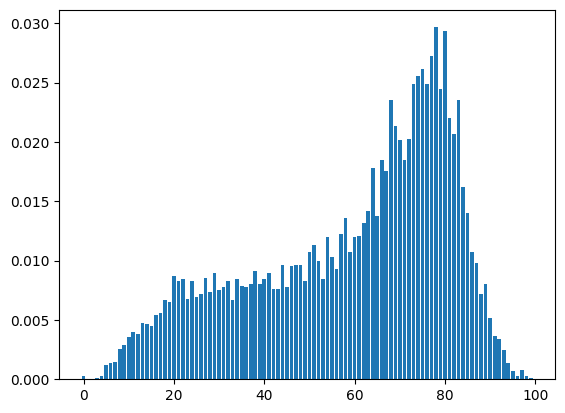

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

INFO:root:Results After Iteration 1.
INFO:root:Creating Dataloaders.
INFO:root:Instantiating models.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:root:Optimizer and Scheduler setup.
INFO:root:Training
  0%|          | 0/15 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |    7    |   0.554690  


INFO:root:Evaluation Head:: Loss=0.6280701926776341 Accuracy=73.11507936507937
  0%|          | 0/15 [00:23<?, ?it/s]


Metrics Report:

Accuracy: 0.7273333333333334
Confusion Matrix:
[[1091    0]
 [ 409    0]]
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:root:Candidate samples count for active learning : 250


Current Active Learning Iteration: 2


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |    7    |   0.586654  


INFO:root:Evaluation Head:: Loss=0.5971486308271923 Accuracy=73.31349206349206
INFO:root:Evaluation Classifier 1:: Loss=0.7820067736837599 Accuracy=27.083333333333332
INFO:root:Evaluation Classifier 2:: Loss=0.6582292233194623 Accuracy=73.11507936507937
  0%|          | 0/15 [00:55<?, ?it/s]
INFO:root:Calculating Discrepancy Scores.


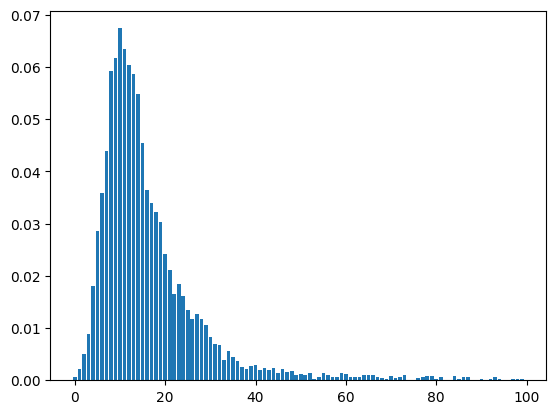

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

INFO:root:Results After Iteration 2.
INFO:root:Creating Dataloaders.
INFO:root:Instantiating models.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:root:Optimizer and Scheduler setup.
INFO:root:Training
  0%|          | 0/15 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   10    |   0.616123  


INFO:root:Evaluation Head:: Loss=0.5278426120205532 Accuracy=73.11507936507937
  0%|          | 0/15 [00:27<?, ?it/s]


Metrics Report:

Accuracy: 0.7273333333333334
Confusion Matrix:
[[1091    0]
 [ 409    0]]
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:root:Candidate samples count for active learning : 350


Current Active Learning Iteration: 3


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   10    |   0.696731  


INFO:root:Evaluation Head:: Loss=0.516799909727914 Accuracy=73.41269841269842
INFO:root:Evaluation Classifier 1:: Loss=0.5737171315011524 Accuracy=73.31349206349206
INFO:root:Evaluation Classifier 2:: Loss=0.6218003271118043 Accuracy=77.08333333333333
  0%|          | 0/15 [01:02<?, ?it/s]
INFO:root:Calculating Discrepancy Scores.


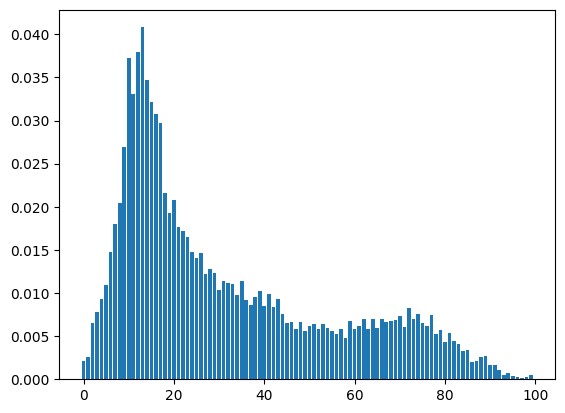

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

INFO:root:Results After Iteration 3.
INFO:root:Creating Dataloaders.
INFO:root:Instantiating models.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:root:Optimizer and Scheduler setup.
INFO:root:Training
  0%|          | 0/15 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   14    |   0.555778  


INFO:root:Evaluation Head:: Loss=0.5813441919902015 Accuracy=73.21428571428571
  0%|          | 0/15 [00:31<?, ?it/s]


Metrics Report:

Accuracy: 0.7273333333333334
Confusion Matrix:
[[1091    0]
 [ 409    0]]
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:root:Candidate samples count for active learning : 450


Current Active Learning Iteration: 4


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   14    |   0.503459  


INFO:root:Evaluation Head:: Loss=0.7528582406895501 Accuracy=59.92063492063492
INFO:root:Evaluation Classifier 1:: Loss=0.6191477671502128 Accuracy=73.41269841269842
INFO:root:Evaluation Classifier 2:: Loss=0.5858306369138142 Accuracy=64.98015873015873
  0%|          | 0/15 [01:10<?, ?it/s]
INFO:root:Calculating Discrepancy Scores.


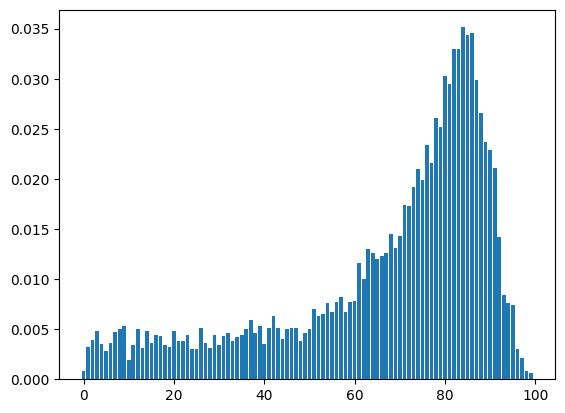

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

INFO:root:Results After Iteration 4.
INFO:root:Creating Dataloaders.
INFO:root:Instantiating models.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:root:Optimizer and Scheduler setup.
INFO:root:Training
  0%|          | 0/15 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   17    |   0.537971  


INFO:root:Evaluation Head:: Loss=0.3577153193099158 Accuracy=88.4920634920635
  0%|          | 0/15 [00:36<?, ?it/s]
INFO:root:Candidate samples count for active learning : 550


Metrics Report:

Accuracy: 0.8853333333333333
Confusion Matrix:
[[1012   79]
 [  93  316]]
Precision: 0.8
Recall: 0.7726161369193154
F1-score: 0.7860696517412936
Current Active Learning Iteration: 5


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   17    |   0.682035  


INFO:root:Evaluation Head:: Loss=0.5478124254279666 Accuracy=73.31349206349206
INFO:root:Evaluation Classifier 1:: Loss=0.6009950230992029 Accuracy=73.11507936507937
INFO:root:Evaluation Classifier 2:: Loss=0.6039864316819206 Accuracy=73.21428571428571
  0%|          | 0/15 [01:17<?, ?it/s]
INFO:root:Calculating Discrepancy Scores.


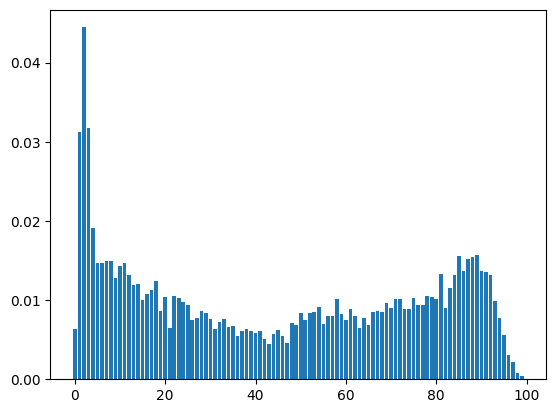

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

INFO:root:Results After Iteration 5.
INFO:root:Creating Dataloaders.
INFO:root:Instantiating models.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:root:Optimizer and Scheduler setup.
INFO:root:Training
  0%|          | 0/15 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   20    |   0.570179  


INFO:root:Evaluation Head:: Loss=0.544442240680967 Accuracy=76.68650793650794
  0%|          | 0/15 [00:40<?, ?it/s]


Metrics Report:

Accuracy: 0.7646666666666667
Confusion Matrix:
[[1089    2]
 [ 351   58]]
Precision: 0.9666666666666667
Recall: 0.14180929095354522
F1-score: 0.24733475479744133


INFO:root:Candidate samples count for active learning : 650


Current Active Learning Iteration: 6


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `p


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   20    |   0.584679  


INFO:root:Evaluation Head:: Loss=0.44212770958741504 Accuracy=73.11507936507937
INFO:root:Evaluation Classifier 1:: Loss=0.5372643324117812 Accuracy=73.11507936507937
INFO:root:Evaluation Classifier 2:: Loss=0.6356100146732633 Accuracy=83.63095238095238
  0%|          | 0/15 [01:24<?, ?it/s]
INFO:root:Calculating Discrepancy Scores.


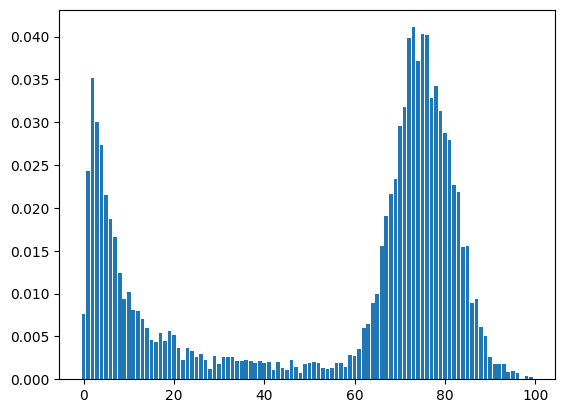

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

INFO:root:Results After Iteration 6.
INFO:root:Creating Dataloaders.
INFO:root:Instantiating models.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:root:Optimizer and Scheduler setup.
INFO:root:Training
  0%|          | 0/15 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   23    |   0.507517  


INFO:root:Evaluation Head:: Loss=0.3451217104281698 Accuracy=88.78968253968254
  0%|          | 0/15 [00:44<?, ?it/s]


Metrics Report:

Accuracy: 0.888
Confusion Matrix:
[[1046   45]
 [ 123  286]]
Precision: 0.8640483383685801
Recall: 0.6992665036674817
F1-score: 0.772972972972973


In [30]:
model, head = run_discrepancy_sampling()

In [36]:
torch.save(model, "./results/model.pt")
torch.save(head, "./results/head.pt")

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
! mv ./results/discrepancy/ ./drive/MyDrive/Thesis/Data/experiments/

### Test Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, do_lower_case=True)

In [ ]:
def is_political(sentence, base_model, classifier):
    input = tokenizer.encode_plus(
                sentence,                      # Sentence to encode.
                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                max_length = 256,           # Pad & truncate all sentences.
                pad_to_max_length = True,
                return_attention_mask = True,   # Construct attn. masks.
                return_tensors = 'pt',     # Return pytorch tensors.
        ).to(DEVICE)
    outputs = base_model(**input)
    last_hidden_state_cls = outputs[0][:, 0, :].to(DEVICE)

    logits = classifier(last_hidden_state_cls)

    is_political = torch.argmax(logits, dim=1).flatten().item()

    if is_political == 0:
        return "👎"
    else:
        return "👍"

In [ ]:
is_political("زندانیان سیاسی را آزاد کنید.", base_model=model, classifier=head)

In [ ]:
is_political("راهمپیمایی امروز نشان دهنده قدرت نظام بود.", base_model=model, classifier=head)

In [ ]:
is_political("زندانیان جرائم سیاسی را باید آزاد کرد", base_model=model, classifier=head)